In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import pytorch_lightning as pl
import os
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [88]:
from PIL import Image
from typing import Any, Callable, Optional, Tuple, List
from collections import defaultdict

class CocoCaptionDataset(torchvision.datasets.vision.VisionDataset):
        def __init__(self, root, annFile, caption_idx = 1, transform = None, target_transform = None, transforms = None):
            super().__init__(root, transforms, transform, target_transform)
            from pycocotools.coco import COCO
            assert caption_idx < 4
            
            self.coco = COCO(annFile)
            self.ids = list(sorted(self.coco.imgs.keys()))
            
            self.caption_idx = caption_idx
            self.vocab_to_idx, self. idx_to_vocab = self._build_vocab_to_idx_mapp()
            self.idx_captions = self._captions_to_idx()
        
        def _build_vocab_to_idx_mapp(self, num_words= 1000):
            
            vocab_count = defaultdict(int)
            for id in self.ids:
                annotations = self.coco.loadAnns(self.coco.getAnnIds(id))
                caption = annotations[self.caption_idx]['caption']
                
                for word in caption.lower().strip('.').split():
                    vocab_count[word] += 1
                    
            special_tokens = [('<NULL>', 0),('<START>', 0),('<END>', 0),('<UNK>', 0)]
            ordered = list(sorted(vocab_count.items(), key= lambda item: item[1], reverse=True))
            first1KTuple = sorted(ordered[:num_words-len(special_tokens)], key = lambda item: item[0])


            vocab_to_idx = {x[0] : i for x, i in zip(special_tokens + first1KTuple, range(num_words))}
            idx_to_vocab = [k for k, v in vocab_to_idx.items()]     
            return vocab_to_idx, idx_to_vocab
        
        def _captions_to_idx(self, fix_length= 16):
            print('Map caption words to idx!!')
            
            master = {}
            for id in tqdm(self.ids):
                annotations = self.coco.loadAnns(self.coco.getAnnIds(id))
                caption = annotations[self.caption_idx]['caption']
                caption = caption.lower().strip('.').split()
                idx = [self.vocab_to_idx['<START>']]
                for i in range(fix_length):
                    
                    if i < len(caption):
                        try:
                            idx.append(self.vocab_to_idx[caption[i]])
                        except:
                            idx.append(self.vocab_to_idx['<UNK>'])
                    elif i == len(caption):
                        idx.append(self.vocab_to_idx['<END>'])
                    
                    else:
                        idx.append(self.vocab_to_idx['<NULL>'])
                    
                    idx_tensor = torch.tensor(idx, dtype=torch.long)
                master[id] = idx_tensor
            return master

        def _load_image(self, id: int) -> Image.Image:
            path = self.coco.loadImgs(id)[0]["file_name"]
            return Image.open(os.path.join(self.root, path)).convert("RGB")

        def _load_target(self, id) -> List[str]:
            return self.idx_captions[id]

        def __getitem__(self, index: int) -> Tuple[Any, Any]:
            id = self.ids[index]
            image = self._load_image(id)
            target = self._load_target(id)

            if self.transforms is not None:
                image, target = self.transforms(image, target)

            return image, target

        def __len__(self) -> int:
            return len(self.ids)
        
        
        
class CocoCaptionsLT(pl.LightningDataModule):
    
    def __init__(self, folder_path, batch_size = 64, caption_idx = 1, transformer = None):
        '''
        Input:
          folder_path: A folder that contains both train and validation images and annotation (.json)
          caption_idx: Original file contain 4 or 5 captions per image. We will only pick one according to index.
          transformers: Pytorch data transforms that will used during preprocess data. 
                        **All data are prepocessed during set up phase. i.e. no transform are used during training**
        '''
        assert caption_idx < 4

        super().__init__()
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.caption_idx = caption_idx
        self.transformer = transformer
        
        self.train_img_path = os.path.join(folder_path, 'train2017')
        self.train_caption_path = os.path.join(folder_path, 'annotations/captions_train2017.json')
        self.val_img_path = os.path.join(folder_path,'val2017')
        self.val_caption_path = os.path.join(folder_path,'annotations/captions_val2017.json')

        if self.transformer is None:
            self.transformer = transforms.Compose([
                                                    transforms.Resize(112),
                                                    transforms.CenterCrop(112),
                                                    transforms.ToTensor()
                                                    ])

        
    def prepare_data(self):
            
        self.train_dataset = CocoCaptionDataset(self.train_img_path, self.train_caption_path, transform = self.transformer)
        self.val_dataset = CocoCaptionDataset(self.val_img_path, self.val_caption_path, transform = self.transformer)
        
        self.vocab_to_idx = self.train_dataset.vocab_to_idx
        self.idx_to_vocab = self.train_dataset.idx_to_vocab
    
    def sample(self, num_samples= 4):
        idx = torch.randint(0, len(self.train_dataset), (num_samples,), dtype=torch.int)
   
        for i in idx:
            img, cap = self.train_dataset[i]
            plt.imshow(img.permute(1,2,0).numpy())
            plt.title(self._decode_captions(cap))
            plt.axis('off')
            plt.show()
    
    def _decode_captions(self, captions):
        """
        Decoding caption indexes into words.
        Inputs:
        - captions: Caption indexes in a tensor of shape (Nx)T.
        - idx_to_word: Mapping from the vocab index to word.
        Outputs:
        - decoded: A sentence (or a list of N sentences).
        """
        singleton = False
        if captions.ndim == 1:
            singleton = True
            captions = captions[None]
        decoded = []
        N, T = captions.shape
        for i in range(N):
            words = []
            for t in range(T):
                word = self.idx_to_vocab[captions[i, t]]
                if word != '<NULL>':
                    words.append(word)
                if word == '<END>':
                    break
            decoded.append(' '.join(words))
        if singleton:
            decoded = decoded[0]
        return decoded
    
    def train_dataloader(self):
        trainDataLoader = torch.utils.data.DataLoader(self.train_dataset, self.batch_size,
                                                      shuffle=True, num_workers=8, pin_memory=True)
        return trainDataLoader
    
    def val_dataloader(self):
        valDataLoader = torch.utils.data.DataLoader(self.val_dataset, self.batch_size,
                                                      shuffle=True, num_workers=8, pin_memory=True)
        return valDataLoader

In [89]:
dataModuleLT = CocoCaptionsLT('/home/fred/datasets/coco/')
dataModuleLT.prepare_data()

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Map caption words to idx!!


  0%|          | 0/118287 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Map caption words to idx!!


  0%|          | 0/5000 [00:00<?, ?it/s]

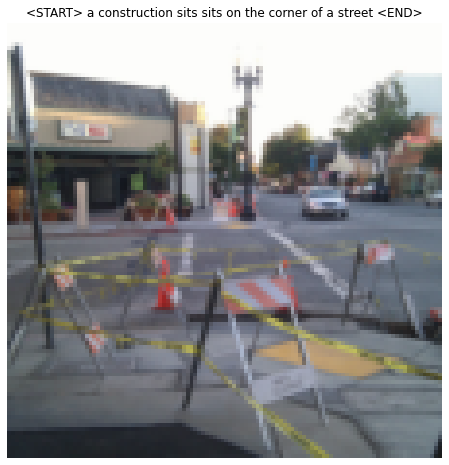

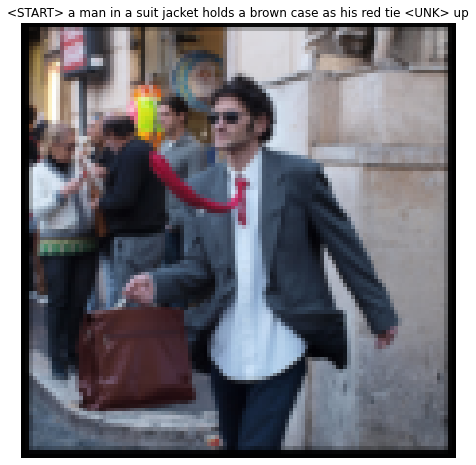

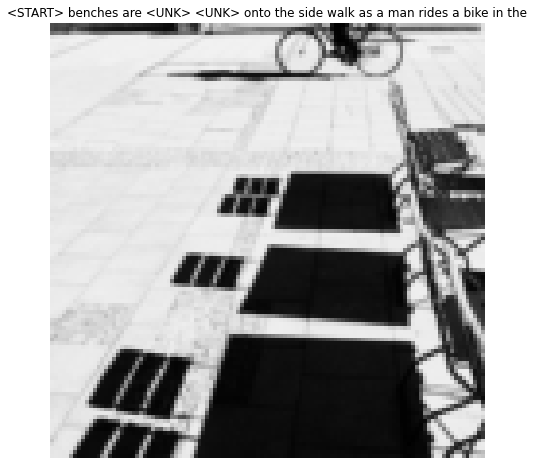

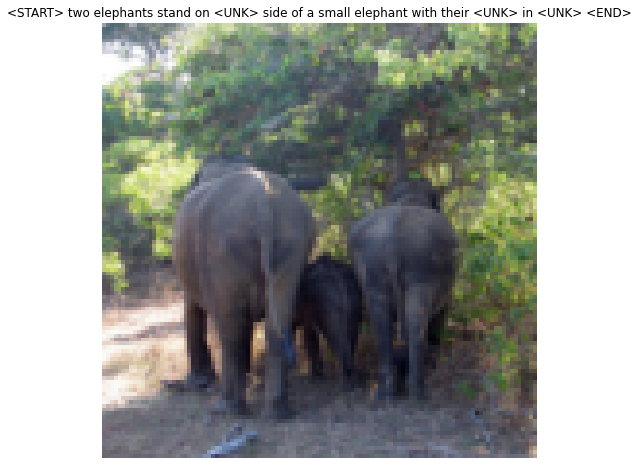

In [90]:
dataModuleLT.sample()

In [84]:
root = '/home/fred/datasets/coco/train2017/'
ann_file = '/home/fred/datasets/coco/annotations/captions_train2017.json'
data = CocoCaptionDataset(root, ann_file)

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
Map caption words to idx!!


  0%|          | 0/118287 [00:00<?, ?it/s]